In [1]:
from scipy import misc
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

(320, 320, 4)


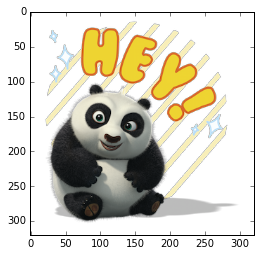

In [2]:
imag = misc.imread('/home/ubuntu/data/images/Kung Fu Panda/Hey!_S006.png')
print imag.shape
plt.imshow(imag)
plt.show()

In [3]:
#load all the images as a 320x320 images from the images folder
imageFolder = '/home/ubuntu/data/images/'

#loop through the folder and create matrix
X = []
Y = []

for fn in os.listdir(imageFolder):
    filePath = imageFolder + fn + '/'
    for fileName in os.listdir(filePath):
        assetPath = filePath + fileName
        imArray = misc.imread(assetPath)
        imShape = imArray.shape
        
        if imShape[0] == 320:
            X.append(imArray)
            Y.append(fn)

X = np.asarray(X)
Y = np.asarray(Y)

print X.shape
print Y.shape

(1618, 320, 320, 4)
(1618,)


In [4]:
#calculate the number of output we want i.e tags
# do a one hot encoding as well
tags = {}
ctr = 0
for i in np.nditer(Y):
    if str(i) not in tags:
        tags[str(i)] = ctr
        ctr = ctr + 1

In [5]:
noOfTags = len(tags)

In [6]:
#one hot encoding
Y_copy = Y
#enumerate Y to change it to numbers
for label in np.nditer(Y_copy, op_flags=['readwrite']):
    if str(label) in tags:
        label[...] = tags[str(label)]

print Y_copy


['0' '0' '0' ..., '61' '61' '61']


In [7]:

labelY = []

for label in np.nditer(Y_copy):
    temp=np.zeros(noOfTags)
    temp[int(str(label))] = 1
    labelY.append(temp)

labelY = np.asarray(labelY)
    

In [8]:
#so the input is X and output is labelY
X_in = X
Y_in = labelY

shape_X = X_in.shape

labelNodes = noOfTags
height = shape_X[1]
width = shape_X[2]
channel = shape_X[3]
tags = labelNodes
patch = 5
depth = 16
num_hidden = 128

learning_rate = 0.00001

In [9]:
tf_X = tf.placeholder("float", shape=[None, height, width, channel])
tf_Y = tf.placeholder("float", shape=[None, tags])

convW1 = tf.Variable(tf.random_normal([patch, patch, channel, depth], stddev=0.1))
bias1 = tf.Variable(tf.random_normal([depth], stddev=0.1))

convW2 = tf.Variable(tf.random_normal([patch, patch, depth, depth], stddev=0.1))
bias2 = tf.Variable(tf.random_normal([depth], stddev=0.1))

w3 = tf.Variable(tf.random_normal([height // 4 * width // 4 * depth, num_hidden], stddev=0.1))
bias3 = tf.Variable(tf.random_normal([num_hidden]))

w4 = tf.Variable(tf.random_normal([num_hidden, tags], stddev=0.1))
bias4 = tf.Variable(tf.random_normal([tags], stddev=0.1))              


In [10]:
#model
def model(X):
    conv = tf.nn.conv2d(X, convW1, [1,2,2,1], padding='SAME')
    hidden1 = tf.nn.relu(conv + bias1)
    
    conv2 = tf.nn.conv2d(hidden1, convW2, [1,2,2,1], padding='SAME')
    hidden2 = tf.nn.relu(conv2 + bias2)
    
    #reshape it to a single Dimensional
    shape = hidden2.get_shape()
    print hidden2.get_shape().as_list()
    
    newInput = tf.reshape(hidden2, [-1, shape[1].value * shape[2].value * shape[3].value])
    hidden3 = tf.nn.relu(tf.matmul(newInput, w3) + bias3)
    
    return tf.matmul(hidden3, w4) + bias4

In [11]:
pred = model(tf_X)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, tf_Y))

# Optimizer.
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(pred,1),tf.argmax(tf_Y,1)), "float"))

[None, 80, 80, 16]


In [ ]:
def Accuracy(X, Y, message, sess):    
    print message, sess.run(accuracy, feed_dict= {tf_X: X, tf_Y: Y})

In [ ]:
with tf.Session() as sess:
    tf.initialize_all_variables().run()
    epoch = 1000
    batch_size = 16
    test_size = 100
    print('Initialized')
    
    p = np.random.permutation(range(len(X_in)))
    trX, trY = X_in[p], Y_in[p]
    
    testX = X_in[:100]
    testY = Y_in[:100]
    
    trX = X_in[100:]
    trY = Y_in[100:]
    
    for step in range(epoch):       
        
        sess.run(optimizer, feed_dict= {tf_X: trX, tf_Y: trY})
        
        if step % 50 == 0:
            print 'cost at each step :', step, 'is :', sess.run(loss, feed_dict={tf_X: trX, tf_Y: trY})
    
    Accuracy(X_in, Y_in, 'accuracy of training data : ', sess)
    Accuracy(testX, testY, 'accuracy of test data : ', sess)

Initialized
